## Hyperparameter Tuning (using Otto Group Product Data)

이번 과제는 머신러닝 모델의 Hyperparameter를 튜닝하여 예측모델을 만들어보겠습니다.
오늘 사용할 데이터는 세계 최대의 전자상거래 회사 중 하나인 [Otto Group](https://www.ottogroup.com/)에서 주최하는 [Otto Group Product Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge/) 경진대회에서 제공하는 데이터입니다. 

<img src="https://drive.google.com/uc?export=download&id=1AhEKfkKPfe2Ju1UQa39vJn0r4k3Fgklx" width="640px" />

<center><small><a href="https://www.kaggle.com/c/otto-group-product-classification-challenge/">Otto Group Product Classification Challenge 경진대회</a></small></center>

<br />

Otto Group은 익명화(anonymization)된 상품 정보에 대한 데이터를 제공하는데, 경진대회 참석자는 이 데이터를 활용하여 주어진 상품 카테고리(target)를 예측해야 합니다. 상품 카테고리는 ```Class_1```부터 ```Class_9```까지 총 9개가 있습니다. 주어진 데이터를 의사결정나무(Decision Tree), 랜덤 포레스트(Random Forest), 그리고 그래디언트 부스팅 머신(Gradient Boosting Machine)를 활용하여 예측해보도록 하겠습니다.

### Prerequisites

경진대회에 참여하기에 앞서, 오늘 필요한 파이썬 패키지를 읽어오겠습니다. 가장 먼저 필요한 패키지는 파이썬에서 데이터를 분석하는데 도움을 주는 패키지 판다스([Pandas](https://pandas.pydata.org/)) 입니다. 이 패키지를 먼저 읽어오겠습니다.

In [1]:
# 파이썬에서 데이터를 분석해주는 패키지 판다스(Pandas)를 읽어옵니다.
# 이를 pd라는 축약어로 사용합니다.
import pandas as pd

### Load Dataset

예측모델을 만들기 위해선 먼저 데이터를 읽어와야 합니다.

모든 데이터 분석의 시작은 주어진 데이터를 읽어오는 것입니다. 판다스([Pandas](https://pandas.pydata.org/))에는 [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)라는 기능이 있는데, 이 기능을 활용하면 csv ([Comma Separated Values](https://en.wikipedia.org/wiki/Comma-separated_values)) 데이터를 편리하게 데이터를 읽어올 수 있습니다. ```read_csv```를 활용해 이 경진대회에서 제공하는 두 개의 데이터(train, test)를 읽어오겠습니다. (데이터는 [다음의 링크](https://www.kaggle.com/c/otto-group-product-classification-challenge/data)에서 다운받으실 수 있습니다)

여기서 파일의 경로를 지정하는 방법에 주의하셔야 합니다. 파일 경로 지정은 컴퓨터의 설정마다 천차만별로 다르기 때문에 사전에 컴퓨터의 경로 지정 개념을 숙지해두셔야 합니다. 만일 ```read_csv```를 실행할 때 ```FileNotFoundError```라는 에러가 난다면 경로가 제대로 지정이 되지 않은 것입니다. **만일 파일의 경로를 지정하는 법이 생각나지 않는다면 [다음의 링크](https://88240.tistory.com/122)를 통해 경로를 지정하는 법을 복습한 뒤 다시 시도해주세요.**

In [2]:
# 먼저 판다스(Pandas)를 활용해 test.csv 파일을 읽어옵니다.
# 여기에서 인덱스(index)로 train 데이터의 id 컬럼을 사용합니다.
# 그리고 읽어온 데이터를 train이라는 이름의 변수에 저장합니다.
train = pd.read_csv("data/train.csv", index_col="id")

# train 변수에 할당한 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(train.shape)

# head()로 train 데이터의 상위 5개를 띄웁니다.
train.head()

(61878, 94)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
4,1,0,0,1,6,1,5,0,0,1,...,0,1,2,0,0,0,0,0,0,Class_1
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


### Preprocessing

가장 먼저 해야 하는 준비는 데이터를 정리하는 것입니다. 데이터를 의사결정나무(Decision Tree), 랜덤 포레스트(Random Forest), 또는 그래디언트 부스팅 머신(Gradient Boosting Machine)과 같은 머신러닝 알고리즘에 넣기 위해서는, 사전에 데이터를 머신러닝 알고리즘이 이해할 수 있는 형태로 변환해줘야 합니다. 이 과정을 전문용어로 전처리(Preprocessing)라고 합니다.

오늘 학습할 머신러닝 알고리즘(내지는 지도학습(Supervised Learning) 알고리즘)에 데이터를 넣기 위해서는, 데이터를 두 가지 형태로 나눠줘야 합니다.

* **Label**: 레이블(Label), 내지는 타겟 변수(Target Variable)이라고 부릅니다. (몇몇 곳에서는 Class라고도 부릅니다) 쉽게 말해 우리가 맞춰야 하는 정답입니다.
* **Feature**: 우리가 label을 맞추는데 도움이 되는 값들입니다. 오늘 데이터에서는 label을 제외한 사실상 모든 컬럼들이 Feature가 될 수 있습니다.

이번 과제에서는 다음의 컬럼을 Feature와 Label로 활용할 것입니다.

* **Feature**: ```target``` 컬럼을 제외한 나머지 모든 컬럼
* **Label**: ```target``` 컬럼

위에서 언급한 방식 그대로 **Feature**와 **Label**을 만들어 보겠습니다.

In [3]:
# target이라는 이름의 컬럼을 label_name 이라는 이름의 변수에 할당합니다.
# 이 컬럼이 실질적으로 이번 경진대회의 Label이 됩니다.
label_name = "target"

# label_name 안에 들어있는 값을 출력하면, 예상대로 target이 출력되는것을 알 수 있습니다.
label_name

'target'

In [4]:
# label_name에 지정된 컬럼을 제외한 나머지 모든 컬럼을 Feature로 간주할 것입니다.
# 이를 feature_names라는 이름의 컬럼에 할당하겠습니다.
feature_names = train.columns.difference([label_name])

# feature_names의 길이(length, len)를 잽니다. 그리고 이를 바로 출력합니다.
# 전체 train 데이터의 컬럼 개수에서, target 컬럼 하나를 제외한 총 93개가 출력됩니다.
print(len(feature_names))

# feature_names 안에 들어가 있는 값의 상위 5개를 출력하면, Feature들의 몇몇 예시를 볼 수 있습니다.
feature_names[0:5]

93


Index(['feat_1', 'feat_10', 'feat_11', 'feat_12', 'feat_13'], dtype='object')

### Train


이제 본격적으로 학습에 들어가기 전, train 데이터를 feature와 label로 나눌 것입니다.

* ```X```: train 데이터의 feature 입니다. 
* ```y```: train 데이터의 label 입니다.

이제 앞서 지정한 feature와 label을 활용해 ```X```, ```y```을 각각 만들어 보겠습니다.

In [5]:
# feature_names를 활용해 train 데이터의 feature를 가져옵니다.
# 이를 X라는 이름의 변수에 할당합니다. 
X = train[feature_names]

# X 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(X.shape)

# X 데이터의 상위 5개를 띄웁니다.
X.head()

(61878, 93)


,feat_1,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_9,feat_90,feat_91,feat_92,feat_93
id,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,0,0,0,0,2,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,1,0,0,1,1,0,...,0,1,2,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,4,0,...,1,0,0,0,0,0,1,0,0,0


In [6]:
# label_name을 활용해 train 데이터의 label을 가져옵니다.
# 이를 y이라는 이름의 변수에 할당합니다.
y = train[label_name]

# unique 함수를 사용하여 y 안에 들어가 있는 값의 중복을 제거합니다.
# 이렇게 하면 y 안에 있는 값의 종류가 나오며, Class_1부터 Class_9까지 총 9개의 종류가 나옵니다.
# 이것을 Label의 종류, 앞으로는 클래스(Class)라고 부르겠습니다.
print(y.unique())

# y 변수에 할당된 데이터의 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시되나, column이 없기 때문에 (row,) 형태로 표시될 것입니다.
print(y.shape)

# y 데이터의 상위 5개를 띄웁니다.
y.head()

['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']
(61878,)


id
1    Class_1
2    Class_1
3    Class_1
4    Class_1
5    Class_1
Name: target, dtype: object

### Hold-out Validation

모델의 정확도를 평가하기 위해서는 가지고 있는 모든 데이터를 학습데이터(train)로 넣어주지 않고, train과 test데이터로 나누어 주어야합니다.

나누어준 후, train데이터로 학습을 시켜주고 test데이터로 모델의 성능을 측정합니다.

In [7]:
# scikit-learn의 model_selection 모듈에서 train_test_split 함수를 가져옵니다.
# 이 함수를 활용해서 Hold-out validation을 할 것입니다.
from sklearn.model_selection import train_test_split

# train_test_split 을 실행합니다. train 데이터, 정확히는 X와 y를 나눌 것이며,
# 비율은 학습용 데이터를 70%, 검증용 데이터를 30%로 나눌 것입니다.
# 이를 각각 X_train, X_test, y_train, y_test 라는 값으로 받습니다.
# (여기서 결과가 매 번 바뀌는 현상을 방지하기 위해, random_state를 사용해서 랜덤 값을 고정할 것입니다.)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3, random_state = 42)

# Train data와 Test data가 잘 나눠졌는지 각각의 데이터의 갯수를 출력하여 확인합니다.
# train데이터는 43314개, test데이터는 18564개입니다.
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

43314 43314
18564 18564


## Use Random Forest

이번에 사용할 알고리즘은 랜덤 포레스트([Random Forest](https://en.wikipedia.org/wiki/Random_forest))입니다. 랜덤포레스트 알고리즘의 개략적인 동작 원리는 다음과 같습니다.

 1. 먼저 전체 데이터를 그대로 쓰는게 아니라, 중복을 허용한다는 가정 하에 동일한 개수로 다시 한 번 샘플링(=[복원 추출](https://zetawiki.com/wiki/%EB%B3%B5%EC%9B%90%EC%B6%94%EC%B6%9C,_%EB%B9%84%EB%B3%B5%EC%9B%90%EC%B6%94%EC%B6%9C))을 합니다. 이를 베깅(bagging), 내지는 부트스트랩 어그리게이팅(bootstrap aggregating)이라고 합니다.
 1. 이렇게 샘플링한 데이터마다 머신러닝 알고리즘 중 하나인 의사결정나무([DecisionTree](https://en.wikipedia.org/wiki/Decision_tree))를 학습시킵니다
 1. 1번의 방식을 사용하면 이론적으로 무제한의 의사결정나무를 만들 수 있습니다. 이 의사결정나무를 지정한 갯수(=```n_estimators```)만큼 생성합니다.
 1. 생성한 트리끼리 투표를 합니다. 가령 otto 상품분류 데이터를 기준으로, 1,000개의 트리 중 300개가 Class1이라고 판단하고 / 200개가 Class2라고 판단하면 해당 상품의 카테고리는 Class1이라고 판단합니다. 정 반대로 300개가 Class2라고 판단하고 / 200개가 Class1라고 판단하면 해당 상품의 카테고리는 Class2라고 판단합니다.
 
이러한 방식을 거치면 의사결정나무(Decision Tree)를 포함한 다른 알고리즘보다 더 강력한 알고리즘을 구현할 수 있습니다. (자세한 설명은 [다음의 링크](http://swalloow.tistory.com/92)를 참고 바랍니다)

이번에도 파이썬의 머신러닝 패키지인 [scikit-learn](https://scikit-learn.org/)에서 랜덤 포레스트를 가져오겠습니다. 

In [8]:
# scikit-learn 패키지의 ensemble 모듈에 있는 RandomForestClassifier를 가지고 옵니다.
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier를 생성합니다.
# 1) n_jobs. 병렬처리 여부입니다. -1을 대입하면 컴퓨터에 존재하는 모든 코어(Core, ex: 듀얼코어, 쿼드코어)를 전부 활용합니다.
# 2) random_state. 랜덤포레스트의 결과가 랜덤하게 나오는 것을 고정하는 옵션입니다. 아무 숫자나 넣어주면 됩니다. (공학 용어에서 쓰이는 Seed Number와 동일한 개념입니다)
model = RandomForestClassifier(random_state = 42, n_jobs = -1)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [9]:
# RandomForestClassifier를 학습(fitting)합니다. train 데이터의 feature(X_train)와 label(y_train)을 집어넣습니다.
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [10]:
# X_train, X_test를 입력으로 predict(예측)한 결과를 각각 y_train_predict, y_test_predict라는 이름의 변수에 할당합니다.
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

# 예측값(y_train_predict, y_test_predict)이 얼마나 정답값(y)을 잘 맞췄는지 정확도를 계산합니다.
train_score = (y_train == y_train_predict).mean()
test_score = (y_test == y_test_predict).mean()

# train, test 데이터의 각각의 예측 정확도를 출력해봅니다.
f"train = {train_score:.6f}, test = {test_score:.6f}"

'train = 0.993028, test = 0.779412'

### Hyperparameter

이제, 모델(model)의 Hypterparameter를 조정해봅시다. 

sklearn의 RandomForestClassifier에서는 아래와 같은 다양한 옵션들 세팅할 수 있습니다.
* 기본적으로 DecisionTreeClassifier에서 썼던 max_depth, min_samples_split, min_samples_leaf 등등
* **n_estimators**
* **max_features**
* **class_weight**
* 이 외, RandomForestClassifier의 더욱 다양한 hyperparameter들에 대한 설명은 [이 곳 링크](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)에서 확인하실 수 있습니다.


각각의 hyperparameter가 어떤 특성을 가지고 있는지, 해당 Hyperparameter의 값에 따라 모델의 성능(정확도)가 어떻게 달라지는지 살펴보겠습니다.

### Random Forest - n_estimators

가장 먼저, RandomForest 모델에서 가장 중요한 n_estimators(트리의 개수)를 살펴보고자 합니다. 

* **n_estimators** : 생성할 의사결정나무의 개수. default 값은 10. (0.22버전에서는 100)  


 
```n_estimators```(트리의 개수)를 지정해주어 여러개의 트리를 만들어 주면, 훈련 데이터에 오버피팅이 되는 경향을 가진 의사결정나무 모델의 단점을 해결할 수 있습니다. 따라서 ```n_estimators```(트리의 개수)는 클수록 좋습니다.  하지만, 그만큼 트리모형을 많이 만들어야하므로 메모리와 훈련 시간이 증가합니다. 

```n_estimators```의 값에 따라 정확도가 어떻게 변하는지 확인해봅시다.

In [11]:
# range함수를 이용하여 n_estimators_list에 10부터 200까지 10단위로 자연수를 생성합니다.
n_estimators_list = range(10, 201, 10)

# 각각의 n_estimators에 따른 결과를 저장하기 위한 리스트(history)를 만듭니다.
history = []

# n_estimators_list에 있는 숫자만큼 돌릴 for문을 선언합니다.
for n_estimators in n_estimators_list:
    
    # RandomForestClassifier를 생성하여 model이라는 이름의 변수에 할당합니다. 
    # n_jobs. 병렬처리 여부입니다. -1을 대입하면 컴퓨터에 존재하는 모든 코어(Core, ex: 듀얼코어, 쿼드코어)를 전부 활용합니다.
    # n_estimators(트리의 개수)를 n_estimators로 지정해줍니다.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   n_jobs = -1,
                                   random_state = 42)
    
    # 생성한 model을 학습(fitting)합니다. train 데이터의 feature(X_train)와 label(y_train)을 집어넣습니다.
    model.fit(X_train, y_train)
    
    # X_train, X_test를 입력으로 predict(예측)한 결과를 각각 y_train_predict, y_test_predict라는 이름의 변수에 할당합니다.
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    # 예측값(y_train_predict, y_test_predict)이 얼마나 정답값(y)을 잘 맞췄는지 정확도를 계산합니다.
    train_score = (y_train == y_train_predict).mean()
    test_score = (y_test == y_test_predict).mean()
    
    # n_estimators에 따른 train, test 데이터의 각각의 예측 정확도를 출력해봅니다.
    print(f"n_estimators = {n_estimators}, train = {train_score:.6f}, test = {test_score:.6f}")
    
    # n_estimators에 따른 train, test 데이터에 대한 예측 정확도를 history에 저장합니다.
    history.append({
        'n_estimators': n_estimators,
        'train': train_score,
        'test': test_score,
    })

# 결과를 판다스의 DataFrame형태로 변형하여 출력합니다.
history = pd.DataFrame(history)
history

n_estimators = 10, train = 0.993028, test = 0.779412
n_estimators = 20, train = 0.998453, test = 0.796811
n_estimators = 30, train = 0.999561, test = 0.800690
n_estimators = 40, train = 0.999885, test = 0.805484
n_estimators = 50, train = 1.000000, test = 0.807315
n_estimators = 60, train = 1.000000, test = 0.807746
n_estimators = 70, train = 1.000000, test = 0.807315
n_estimators = 80, train = 1.000000, test = 0.809093
n_estimators = 90, train = 1.000000, test = 0.809632
n_estimators = 100, train = 1.000000, test = 0.809901
n_estimators = 110, train = 1.000000, test = 0.809739
n_estimators = 120, train = 1.000000, test = 0.809685
n_estimators = 130, train = 1.000000, test = 0.810547
n_estimators = 140, train = 1.000000, test = 0.810709
n_estimators = 150, train = 1.000000, test = 0.810170
n_estimators = 160, train = 1.000000, test = 0.811140
n_estimators = 170, train = 1.000000, test = 0.811248
n_estimators = 180, train = 1.000000, test = 0.811409
n_estimators = 190, train = 1.000000,

,n_estimators,train,test
0,10,0.993028,0.779412
1,20,0.998453,0.796811
2,30,0.999561,0.800690
3,40,0.999885,0.805484
4,50,1.000000,0.807315
5,60,1.000000,0.807746
6,70,1.000000,0.807315
7,80,1.000000,0.809093
8,90,1.000000,0.809632
9,100,1.000000,0.809901


이제, ```n_estimators```에 따른 학습결과(정확도)를 시각화 해봅시다.

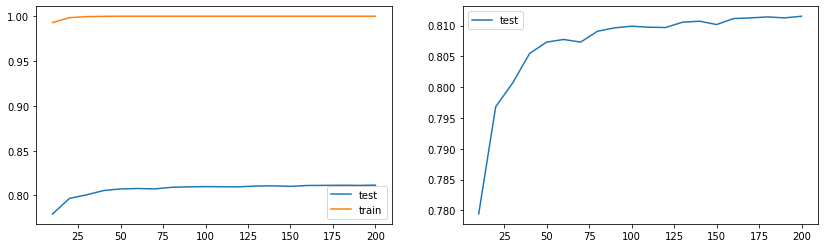

In [12]:
# 주피터 노트북에서 그림을 바로 띄워주도록 합니다. 
%matplotlib inline
# 학습결과를 그래프로 그려주는 matplotlib의 pyplot모듈을 불러옵니다.
import matplotlib.pyplot as plt

# 그래프의 크기를 설정합니다. 가로 14, 세로 4
plt.figure(figsize = (14, 4))

# pyplot의 plot으로 x축에는 n_estimators값을 y축에는 train,test데이터에 대한 모델의 예측정확도값을 넣어줍니다.
# nrows=1, ncols=2인 서브플롯에서 첫번째 위치에 그래프를 그립니다.
plt.subplot(1,2,1)
plt.plot(history['n_estimators'], history['test'], label='test')
plt.plot(history['n_estimators'], history['train'], label='train')
# 범례를 출력합니다. 
plt.legend()

# test데이터에 대한 모델의 예측정확도 값만 따로 그려줍니다.
# nrows=1, ncols=2인 서브플롯에서 두번째 위치에 그래프를 그립니다.
plt.subplot(1,2,2)
plt.plot(history['n_estimators'], history['test'], label='test')

# 범례를 출력합니다.
plt.legend()

```n_estimators```값이 클수록 train, test 에 대한 모델의 정확도가 꾸준히 증가합니다. 

### Random Forest - max_features

다음으로, ```max_features```(무작위로 선택할 feature의 개수)를 살펴보고자 합니다. 

* **max_features** : 무작위로 선택할 feature의 개수. Default값은 sqrt(전체features개수). 복원추출을 할때, 지정된 개수만큼의 features 수를 선택합니다. 0에서 1사이의 실수 값을 넣으면, 전체 features 수에 대한 비중으로 인식합니다.

 
```max_features```값이 클수록 특성 선택의 무작위성이 줄어들어 랜덤포레스트의 트리들이 매우 비슷해지고, 반대로 값이 작을수록 트리들이 서로 매우 달라질 것입니다.  

```max_features```의 값에 따라 정확도가 어떻게 변하는지 확인해봅시다.

In [13]:
# max_features_list에 0.05부터 0.95까지 0.05단위로 19개의 실수를 생성합니다.
max_features_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
                     0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# 각각의 max_features에 따른 결과를 저장하기 위한 리스트(history)를 만듭니다.
history = []

# max_features_list에 있는 숫자만큼 돌릴 for문을 선언합니다.
for max_features in max_features_list:
    
    # RandomForestClassifier를 생성하여 model이라는 이름의 변수에 할당합니다. 
    # n_jobs. 병렬처리 여부입니다. -1을 대입하면 컴퓨터에 존재하는 모든 코어(Core, ex: 듀얼코어, 쿼드코어)를 전부 활용합니다.
    # max_features(트리의 개수)를 max_features로 지정해줍니다.
    model = RandomForestClassifier(max_features = max_features,
                                   n_estimators = 10,
                                   n_jobs = -1,
                                   random_state = 42)
    
    # 생성한 model을 학습(fitting)합니다. train 데이터의 feature(X_train)와 label(y_train)을 집어넣습니다.
    model.fit(X_train, y_train)
    
    # X_train, X_test를 입력으로 predict(예측)한 결과를 각각 y_train_predict, y_test_predict라는 이름의 변수에 할당합니다.
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    # 예측값(y_train_predict, y_test_predict)이 얼마나 정답값(y)을 잘 맞췄는지 정확도를 계산합니다.
    train_score = (y_train == y_train_predict).mean()
    test_score = (y_test == y_test_predict).mean()
    
    # max_features에 따른 train, test 데이터의 각각의 예측 정확도를 출력해봅니다.
    print(f"max_features = {max_features}, train = {train_score:.6f}, test = {test_score:.6f}")
    
    # max_features에 따른 train, test 데이터에 대한 예측 정확도를 history에 저장합니다.
    history.append({
        'max_features': max_features,
        'train': train_score,
        'test': test_score,
    })

# 결과를 판다스의 DataFrame형태로 변형하여 출력합니다.
history = pd.DataFrame(history)
history

max_features = 0.05, train = 0.993651, test = 0.766376
max_features = 0.1, train = 0.993028, test = 0.779412
max_features = 0.15, train = 0.992520, test = 0.780812
max_features = 0.2, train = 0.992958, test = 0.784960
max_features = 0.25, train = 0.992566, test = 0.782374
max_features = 0.3, train = 0.991966, test = 0.781136
max_features = 0.35, train = 0.992266, test = 0.787330
max_features = 0.4, train = 0.992450, test = 0.783183
max_features = 0.45, train = 0.992404, test = 0.784044
max_features = 0.5, train = 0.992381, test = 0.785607
max_features = 0.55, train = 0.991619, test = 0.783021
max_features = 0.6, train = 0.992058, test = 0.783991
max_features = 0.65, train = 0.991573, test = 0.786792
max_features = 0.7, train = 0.991781, test = 0.783183
max_features = 0.75, train = 0.991250, test = 0.783721
max_features = 0.8, train = 0.992450, test = 0.780112
max_features = 0.85, train = 0.991712, test = 0.784906
max_features = 0.9, train = 0.991296, test = 0.782267
max_features = 0.95

,max_features,train,test
0,0.05,0.993651,0.766376
1,0.10,0.993028,0.779412
2,0.15,0.992520,0.780812
3,0.20,0.992958,0.784960
4,0.25,0.992566,0.782374
5,0.30,0.991966,0.781136
6,0.35,0.992266,0.787330
7,0.40,0.992450,0.783183
8,0.45,0.992404,0.784044
9,0.50,0.992381,0.785607


학습이 완료되었으면 이제, ```max_features```에 따른 학습결과(정확도)를 시각화 해봅시다.

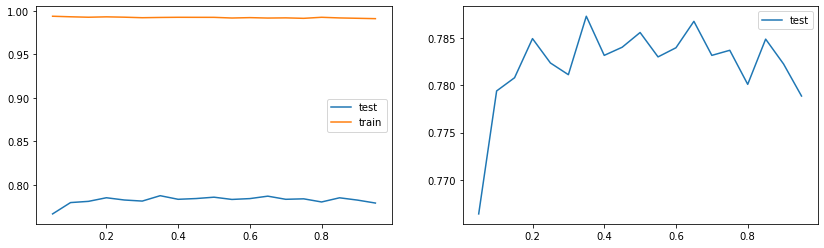

In [14]:
# 주피터 노트북에서 그림을 바로 띄워주도록 합니다. 
%matplotlib inline
# 학습결과를 그래프로 그려주는 matplotlib의 pyplot모듈을 불러옵니다.
import matplotlib.pyplot as plt

# 그래프의 크기를 설정합니다. 가로 14, 세로 4
plt.figure(figsize = (14, 4))

# pyplot의 plot으로 x축에는 max_features값을 y축에는 train,test데이터에 대한 모델의 예측정확도값을 넣어줍니다.
# nrows=1, ncols=2인 서브플롯에서 첫번째 위치에 그래프를 그립니다.
plt.subplot(1,2,1)
plt.plot(history['max_features'], history['test'], label='test')
plt.plot(history['max_features'], history['train'], label='train')
# 범례를 출력합니다. 
plt.legend()

# test데이터에 대한 모델의 예측정확도 값만 따로 그려줍니다.
# nrows=1, ncols=2인 서브플롯에서 두번째 위치에 그래프를 그립니다.
plt.subplot(1,2,2)
plt.plot(history['max_features'], history['test'], label='test')

# 범례를 출력합니다.
plt.legend()

```max_features```값이 0.35, 0.6 정도 값에서  test 데이터에 대한 모델의 정확도가 가장 높습니다.

### Random Forest - class_weight

마지막으로, ```class_weight```(class별 가중치)를 살펴보고자 합니다. 

* **class_weight** : bagging을 해줄 때의 각 class별로 가중치를 설정합니다. Default값은 ```None```값으로 모든 Class에 똑같이 1의 비중을 할당. 이 값에 ```"balanced"``` 값을 할당하면, 자동으로 각 class의 비중의 역수의 비율로 비중을 설정해주어 복원추출한 데이터셋의 Class의 비중이 균일해진다. 

 
일반적으로 균등한 class분포를 가지지만 train 데이터 셋의 class 비중이 상이할 때, ```class_weight```값을 ```balanced```로 설정해줍니다.

In [15]:
# train 데이터 셋의 label class 비중을 살펴보기위해, 판다스(pandas)의 value_counts()로 각 class의 개수를 계산합니다.
y_train.value_counts()

Class_2    11322
Class_6     9845
Class_8     5974
Class_3     5643
Class_9     3397
Class_7     1993
Class_4     1904
Class_5     1894
Class_1     1342
Name: target, dtype: int64

train 데이터셋의 각 class별 비중의 차이가 꽤 있음을 볼 수 있습니다.```class_weight```값의 세팅 여부에 따라 모델의 성능이 얼마나 달라지는지 확인해봅시다.

In [16]:
# scikit-learn의 metrics 모듈에 있는 log_loss 함수를 가져옵니다.
# 이 함수가 실제 Multi-class Logarithmic Loss(이하 log loss)를 계산해주는 함수입니다.
from sklearn.metrics import log_loss

# RandomForestClassifier를 생성하여 model이라는 이름의 변수에 할당합니다. 
# n_jobs. 병렬처리 여부입니다. -1을 대입하면 컴퓨터에 존재하는 모든 코어(Core, ex: 듀얼코어, 쿼드코어)를 전부 활용합니다.
# n_estimators 는 100으로 지정해줍니다.
# class_weight를 None로 지정해줍니다.
model = RandomForestClassifier(class_weight = None,
                               n_estimators = 100,
                               n_jobs = -1,
                               random_state = 42)

# 생성한 model을 학습(fitting)합니다. train 데이터의 feature(X_train)와 label(y_train)을 집어넣습니다.
model.fit(X_train, y_train)

# 학습이 끝났으면 predict_proba로 결과를 예측합니다.
# 여기서 predict가 아닌 predict_proba를 사용하는 이유는, 확률(probability)를 받아오기 위해서 그렇습니다.
# (확률을 받아와야 뒤에서 log loss를 계산할 수 있습니다)
# 이 결과를 y_train_predict, y_test_predict라는 이름의 변수에 담아줍니다.
y_train_predict = model.predict_proba(X_train)
y_test_predict = model.predict_proba(X_test)

# 데이터셋의 정답(y_train, y_test)과 예측값(y_train_predict, y_test_predict, 확률)을 활용해 log loss를 계산합니다.
# 이 결과를 train_score, test_score라는 이름의 변수에 할당합니다.train_score = log_loss(y_train, y_train_predict)
test_score = log_loss(y_test, y_test_predict)

# class_weight에 따른 train, test 데이터의 각각의 예측 정확도를 출력해봅니다.
print(f"class weight(None): train = {train_score:.6f}, test = {test_score:.6f}")

# 이번엔 class_weight를 "balanced"로 지정하여 RandomForestClassifier를 다시 생성하여 model이라는 이름의 변수에 할당합니다. 
# n_jobs. 병렬처리 여부입니다. -1을 대입하면 컴퓨터에 존재하는 모든 코어(Core, ex: 듀얼코어, 쿼드코어)를 전부 활용합니다.
# n_estimators 는 100으로 지정해줍니다.
model = RandomForestClassifier(class_weight = "balanced",
                               n_estimators = 100,
                               n_jobs = -1,
                               random_state = 42)

# 생성한 model을 학습(fitting)합니다. train 데이터의 feature(X_train)와 label(y_train)을 집어넣습니다.
model.fit(X_train, y_train)

# 학습이 끝났으면 predict_proba로 결과를 예측합니다.
# 여기서 predict가 아닌 predict_proba를 사용하는 이유는, 확률(probability)를 받아오기 위해서 그렇습니다.
# (확률을 받아와야 뒤에서 log loss를 계산할 수 있습니다)
# 이 결과를 y_train_predict, y_test_predict라는 이름의 변수에 담아줍니다.
y_train_predict = model.predict_proba(X_train)
y_test_predict = model.predict_proba(X_test)

# 데이터셋의 정답(y_train, y_test)과 예측값(y_train_predict, y_test_predict, 확률)을 활용해 log loss를 계산합니다.
# 이 결과를 train_score, test_score라는 이름의 변수에 할당합니다.
train_score = log_loss(y_train, y_train_predict)
test_score = log_loss(y_test, y_test_predict)

# class_weight에 따른 train, test 데이터의 각각의 예측 오차(log loss)를 출력해봅니다.
print(f"class weight(balanced): train = {train_score:.6f}, test = {test_score:.6f}")

class weight(None): train = 0.990881, test = 0.612791
class weight(balanced): train = 0.146726, test = 0.606288


```class_weight```값을 ```"balanced"```로 세팅해주었을때, 모델의 성능이 약간 더 좋아지는 것을 확인할 수 있습니다.

* 이 외, RandomForestClassifier의 더욱 다양한 hyperparameter들에 대한 설명은 [이 곳 링크](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)에서 확인하실 수 있습니다.



## Use Gradient Boosting Machine

이번에는 랜덤포레스트(Random Forest)에 이은 또 다른 머신러닝 모델을 이용해보겠습니다.

이번에 사용할 알고리즘은 그래디언트 부스팅 머신(Gradient Boosting Machine)입니다. 그래디언트 부스팅 머신은 의사결정나무(Decision Tree)에 그래디언트 부스팅(Boosting Machine)이라는 알고리즘을 적용한 모델인데, 정형화 데이터(Structured Data)에 한해서는 가장 강력한 머신러닝 알고리즘이라고 불리우고 있습니다. 알고리즘의 동작 원리는 다음과 같습니다.

  1. 의사결정나무(Decision Tree)를 하나 학습합니다.
  1. 1번에서 학습한 의사결정나무를 통해, 학습(train)데이터를 예측합니다. 그리고 예측값과 정답의 차이(residual)를 계산합니다.
  1. 위 차이(residual)를 보정하는 또 하나의 의사결정나무(Decision Tree)를 학습합니다. 두 번째 의사결정나무에서는 차이를 입력값으로 받고, 차이를 보정하기 위해서는 얼만큼의 보정값이 필요한지를 예측합니다.
위 방식을 끊임없이 반복합니다.

이러한 방식을 거치면 의사결정나무(Decision Tree)보다 더 강력한 알고리즘을 구현할 수 있습니다. 
  
그래디언트 부스팅 머신에는 여러 구현체(Implementation)가 있지만, 여기서는 [scikit-learn](https://scikit-learn.org/)에 들어가 있는 [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)를 사용해보겠습니다.

scikit-learn에 있는 머신러닝 알고리즘을 사용하기 위해서는 크게 두 가지 기능만 숙지하고 있으면 충분합니다.

* ```fit```: 머신러닝 알고리즘을 학습시킵니다. 전문용어로 training, 내지는 fitting한다고 하기 때문에 ```fit```이라는 표현을 사용합니다. fit을 하기 위해서는 train 데이터가 필요하며, 정확히는 train 데이터의 feature(```X_train```)와 label(```y_train```)이 필요합니다.
* ```predict```: ```fit```이 끝나면, 이후에 ```predict```를 통해 예측을 할 수 있습니다. predict를 하기 위해서는 test 데이터가 필요하며, 정확히는 test 데이터의 feature(```X_test```)가 필요합니다.

이 두 가지 기능만 숙지하고 있으면 언제든지 머신러닝 알고리즘을 활용할 수 있습니다.

In [17]:
# scikit-learn(줄여서 sklearn)의 ensemble 모듈에서 GradientBoostingClassifier를 가져옵니다.
from sklearn.ensemble import GradientBoostingClassifier

# GradientBoostingClassifier를 생성하는데, 여기서 옵션(+하이퍼패러미터)는 다음과 같습니다.
# * n_estimators - 나무(tree)의 개수를 지정합니다. 가령 10을 지정하면 총 10개의 나무를 만든다고 볼 수 있습니다.
# * random_state - 알고리즘이 결과를 랜덤하게 내지 않도록 고정해줍니다. 자세한 사항은 이 링크 https://stackoverflow.com/a/28069274 를 참고 바랍니다. 
#  이를 model이라는 이름의 변수에 할당합니다.
model = GradientBoostingClassifier(n_estimators = 10,
                                   random_state = 42)

# model 변수 안에 들어가 있는 값을 출력합니다.
# GradientBoostingClassifier가 성공적으로 생성해서 model 변수에 할당되어 있는 사실을 알 수 있습니다.
model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [18]:
# 위에서 나눈 데이터 중, 70%에 해당하는 학습용 데이터로 머신러닝 모델을 학습(fit)합니다.
# 여기서 %time을 사용하면 학습에 걸리는 시간을 측정할 수 있습니다.
%time model.fit(X_train, y_train)

CPU times: user 21 s, sys: 334 ms, total: 21.4 s
Wall time: 10.7 s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [19]:
# 학습이 끝났으면 predict_proba로 결과를 예측합니다.
# 여기서 predict가 아닌 predict_proba를 사용하는 이유는, 확률(probability)를 받아오기 위해서 그렇습니다.
# (확률을 받아와야 뒤에서 log loss를 계산할 수 있습니다)
# 이 결과를 y_test_predict라는 이름의 변수에 담아줍니다.
y_train_predict = model.predict_proba(X_train)
y_test_predict = model.predict_proba(X_test)

# y_test_predict 변수에 할당된 데이터의 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(y_train_predict.shape, y_test_predict.shape)

# y_test_predict 안에 들어가 있는 값을 출력합니다.
# 데이터셋을 예측한 결과가 확률(probability)로 나올 것입니다.
y_train_predict, y_test_predict

(43314, 9) (18564, 9)


(array([[0.01767009, 0.10209522, 0.05610306, ..., 0.02313969, 0.65354946,
         0.0378314 ],
        [0.0249385 , 0.17072717, 0.13745779, ..., 0.03265797, 0.08564703,
         0.11426017],
        [0.0226575 , 0.1551116 , 0.18963157, ..., 0.35713608, 0.07781332,
         0.04850939],
        ...,
        [0.03786278, 0.21876573, 0.12021549, ..., 0.04958284, 0.22748999,
         0.08106368],
        [0.02677474, 0.31319937, 0.28077913, ..., 0.05600294, 0.08576471,
         0.05907463],
        [0.02801353, 0.34988687, 0.14199095, ..., 0.03668485, 0.15597984,
         0.05997657]]),
 array([[0.0320043 , 0.36709235, 0.13505815, ..., 0.04191091, 0.10991329,
         0.06852074],
        [0.03158484, 0.2016752 , 0.14034841, ..., 0.23565997, 0.11561738,
         0.06968744],
        [0.01170899, 0.06765286, 0.0371764 , ..., 0.01533339, 0.04021252,
         0.02506878],
        ...,
        [0.03462979, 0.23707303, 0.25051677, ..., 0.04534911, 0.11893011,
         0.0741419 ],
        [0.0

In [20]:
# scikit-learn의 metrics 모듈에 있는 log_loss 함수를 가져옵니다.
# 이 함수가 실제 Multi-class Logarithmic Loss(이하 log loss)를 계산해주는 함수입니다.
from sklearn.metrics import log_loss

# 데이터셋의 정답(y_train, y_test)과 예측값(y_train_predict, y_test_predict, 확률)을 활용해 log loss를 계산합니다.
# 이 결과를 train_score, test_score라는 이름의 변수에 할당합니다.
train_score = log_loss(y_train, y_train_predict)
test_score = log_loss(y_test, y_test_predict)

# train, test 데이터의 각각의 예측 오차(log loss)를 출력해봅니다.
print(f"train(log_loss) = {train_score:.6f}, test(log_loss) = {test_score:.6f}")

train(log_loss) = 1.043096, test(log_loss) = 1.040166


### Hyperparameter

이제, 모델(model)의 Hypterparameter를 조정해봅시다. 

sklearn의 GradientBoostingClassifier에서는 아래와 같은 다양한 옵션들 세팅할 수 있습니다.
* 기본적으로 DecisionTreeClassifier에서 썼던 max_depth, min_samples_split, min_samples_leaf 등등

* **n_estimators** : 생성할 의사결정나무의 개수. default 값은 100
* **learning_rate** : 각각의 부스팅 트리가 결과에 미치는 비율. default 값은 0.1 
* 이 외, GradientBoostingClassifier의 더욱 다양한 hyperparameter들에 대한 설명은 [이 곳 링크](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)에서 확인하실 수 있습니다.

 
GradientBoosting모형에서 가장 중요한 ```n_estimators```(트리의 개수)는 일반적으로 클수록 좋지만, 그만큼 트리모형을 많이 만들어야하므로 메모리와 훈련 시간이 증가합니다. 또한, ```learning_rate```의 경우, 기본적으로 0보다 큰 숫자를 적용하되, 너무 크면 각 나무들이 오류를 크게 보정함으로써 성능이 오히려 안 좋아지는 효과가 있습니다. ```learning_rate```가 너무 작을 경우, 상대적으로 ```n_estimators```를 키워야 하므로 학습이 오래 걸리는 문제가 있습니다. 

```n_estimators```와 ```learning_rate```는 일반적으로 서로의 값에 영향을 크게 받습니다. 따라서, 두 옵션값을 함께 조절해가며 score(log loss)가 어떻게 변하는지 확인해보겠습니다. 

In [21]:
# range함수를 이용하여 n_estimators_list에 20부터 200까지 20단위로 자연수를 생성합니다.
n_estimators_list = range(20, 201, 20)
# learning_rate에 0.0001부터 1.0까지 9개 실수를 생성합니다.
learning_rate_list = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]

# 각각의 n_estimators와 learning_rate에 따른 결과를 저장하기 위한 리스트(history)를 만듭니다.
history = []

# n_estimators_list에 있는 숫자만큼 돌릴 for문을 선언합니다.
for n_estimators in n_estimators_list:

    # learning_list에 있는 숫자만큼 돌릴 for문을 선언합니다.
    for learning_rate in learning_rate_list:

        # GradientBoostingClassifier를 생성하여 model이라는 이름의 변수에 할당합니다. 
        # n_estimators(트리의 개수)를 n_estimators로 지정해줍니다.
        # learning_rate를 learning_rate로 지정해줍니다.
        model = GradientBoostingClassifier(n_estimators = n_estimators,
                                       learning_rate = learning_rate,
                                       random_state = 42)

        # 생성한 model을 학습(fitting)합니다. train 데이터의 feature(X_train)와 label(y_train)을 집어넣습니다.
        model.fit(X_train, y_train)

        # 학습이 끝났으면 predict_proba로 결과를 예측합니다.
        # 여기서 predict가 아닌 predict_proba를 사용하는 이유는, 확률(probability)를 받아오기 위해서 그렇습니다.
        # (확률을 받아와야 뒤에서 log loss를 계산할 수 있습니다)
        # 이 결과를 y_test_predict라는 이름의 변수에 담아줍니다.
        y_train_predict = model.predict_proba(X_train)
        y_test_predict = model.predict_proba(X_test)


        # 데이터셋의 정답(y_train, y_test)과 예측값(y_train_predict, y_test_predict, 확률)을 활용해 log loss를 계산합니다.
        # 이 결과를 train_score, test_score라는 이름의 변수에 할당합니다.
        train_score = log_loss(y_train, y_train_predict)
        test_score = log_loss(y_test, y_test_predict)

        # n_estimators와 learning_rate에 따른 train, test 데이터의 각각의 예측 오차(log loss)를 출력해봅니다.

        print(f"n_estimators = {n_estimators}, learning_rate = {learning_rate},\
              train = {train_score:.6f}, test = {test_score:.6f}")

        # n_estimators와 learning_rate에 따른 train, test 데이터에 대한 예측 오차(log loss)를 history에 저장합니다.
        history.append({
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'train': train_score,
            'test': test_score,
        })

# 결과를 판다스의 DataFrame형태로 변형하여 출력합니다.
history = pd.DataFrame(history)
history

n_estimators = 20, learning_rate = 0.0001,              train = 1.943414, test = 1.946892
n_estimators = 20, learning_rate = 0.0003,              train = 1.931807, test = 1.935104
n_estimators = 20, learning_rate = 0.001,              train = 1.893948, test = 1.896722
n_estimators = 20, learning_rate = 0.003,              train = 1.802544, test = 1.804391
n_estimators = 20, learning_rate = 0.01,              train = 1.578740, test = 1.578804
n_estimators = 20, learning_rate = 0.03,              train = 1.238344, test = 1.235938
n_estimators = 20, learning_rate = 0.1,              train = 0.837655, test = 0.837584
n_estimators = 20, learning_rate = 0.3,              train = 0.622335, test = 0.653458
n_estimators = 20, learning_rate = 1.0,              train = 1.359135, test = 1.447562
n_estimators = 40, learning_rate = 0.0001,              train = 1.937566, test = 1.940951
n_estimators = 40, learning_rate = 0.0003,              train = 1.915131, test = 1.918188
n_estimators = 40, learni

,n_estimators,learning_rate,train,test
0,20,0.0001,1.943414,1.946892
1,20,0.0003,1.931807,1.935104
2,20,0.0010,1.893948,1.896722
3,20,0.0030,1.802544,1.804391
4,20,0.0100,1.578740,1.578804
...,...,...,...,...
85,200,0.0100,0.851510,0.851312
86,200,0.0300,0.626481,0.644966
87,200,0.1000,0.477952,0.549776
88,200,0.3000,0.422488,0.600833


학습이 완료되었으면 이제, ```n_estimators```와 ```learning_rate```에 따른 학습결과(log loss)를 시각화 해봅시다.

seaborn의 scatterplot을 통해 시각화를 해보고자 합니다. ```n_estimators```를 x축, ```learning_rate```를 y축, 그리고 그에 따른 학습결과(log loss)값을 원의 크기로 그려보겠습니다. (y축의 경우, log스케일로 바꿔줍니다.)

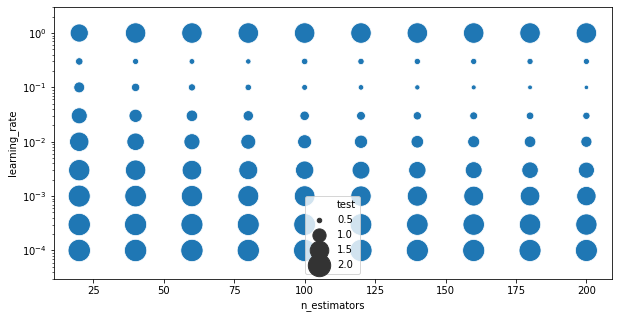

In [22]:
# 주피터 노트북에서 그림을 바로 띄워주도록 합니다. 
%matplotlib inline
# 데이터 시각화 패키지 seaborn을 로딩합니다. 앞으로는 줄여서 sns라고 사용할 것입니다.
import seaborn as sns
# 데이터 시각화 패키지 matplotlib를 로딩합니다. 앞으로는 줄여서 plt라고 사용할 것입니다.
import matplotlib.pyplot as plt

# 그래프의 크기를 설정합니다. 가로 10, 세로 5
plt.figure(figsize = (10, 5))

# seaborn의 scatterplot을 활용하여 n_estimators, learning_rate와 score(log loss)간의 상관관계를 시각화합니다.
# 주의: 이 코드는 seaborn의 버전이 0.9 이상이어야 합니다. 만일 실행이 되자 않는다면 seaborn의 버전을 업그레이트 해주세요.
plot = sns.scatterplot(data=history, x="n_estimators", y="learning_rate", size="test", sizes=(20,500))
# x축을 로그스케일로 바꿉니다. 
plot.set(yscale="log")
# x축의 범위를 0.00003에서 3.0까지로 지정해줍니다. 
plot.set(ylim=(0.00003,3.0))
# 범례를 출력합니다. 
plt.legend()

여기서 원의 크기가 작을수록 log loss값이 작은 것이므로, 더 학습이 잘 된 것입니다. 

```n_estimators```가 클수록, ```learning_rate```는 0.1부근에서 학습이 가장 잘 된 것을 확인할 수 있습니다.

(```n_estimators```가 더 커질수록, 최적의 학습을 위한 ```learning_rate```값은 조금씩 작아집니다!)

* 이 외, GradientBoostingClassifier의 더욱 다양한 hyperparameter들에 대한 설명은 [이 곳 링크](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)에서 확인하실 수 있습니다.